# Sinkhorn Algorithm for Entropy-Regularized Optimal Transport
___
*By Pavlo Pelikh*

In this notebook, we present, maybe, the most popular and well-studied algorithm for solving Entropy-Regularized Optimal Transport (EOT) problem:
$$
    \min_P 
        \sum_{i, j = 1}^n C_{ij} P_{ij} + \varepsilon P_{ij} \log(\frac{P_{ij}}{a_i b_j}) \\
    \operatorname{s.\ t.\ } 
        \sum_{j = 1}^n P_{ij} = a_i \quad \forall i \in [n] \\
        \sum_{i = 1}^n P_{ij} = b_j \quad \forall j \in [n]\\
        P_{ij} \geq 0, \\
$$
where $\textbf{C} \in \mathbb{R}^{n \times n}_+$ is a *cost matrix*, $\textbf{a}, \textbf{b} \in \mathbb{R}^n_+$ are so-called *marginals* such that
$$
    \sum_{i = 1}^n a_i = \sum_{j = 1}^n = M \in \mathbb{R}_+
$$
(usually, $M = 1$), and $\varepsilon > 0$ is a *regularization parameter*.

Compared to the unregularized case, EOT gives the charachterization of the solution form which is (prop. 4.3 in [1])
$$
    P_{ij} = u_i K_{ij} v_j \quad \forall i, j \in [n],
$$
where $K_{ij} = e^{-\frac{C_{ij}}{\varepsilon}}$ a *kernel matrix*, $\textbf{u}, \textbf{v} \in \mathbb{R}^n_+$, the *scaling variables*.

Considering this property, the constraints in the EOT become
$$
    \sum_j u_i K_{ij} v_j = u_i \sum_j K_{ij} v_j = a_i \Leftrightarrow
        \textbf{u} \odot (\textbf{K} \textbf{v}) = \textbf{a}, \\
        \sum_i u_i K_{ij} v_j = v_j \sum_i K_{ij} u_i = b_j \Leftrightarrow
        \textbf{v} \odot (\textbf{K}^T \textbf{u}) = \textbf{b}. \\
$$

This leads to the simple yet effective algorithm.
For the fixed scaling variable $\textbf{v}$, we assign $\textbf{u}$ as follows
$$
    \textbf{u} = \frac{\textbf{a}}{\textbf{K} \textbf{v}},
$$
and in the same manner we get $\textbf{v}$ for the fixed $\textbf{u}$.
By iteratively applying the formula above, we obtain *Sinkhorn algorithm*: pick initial $\textbf{v}^{(0)}$, then compute
$$
    \textbf{u}^{(n+1)} = \frac{\textbf{a}}{K \textbf{v}^{(n)} } 
    \qquad
    \textbf{v}^{(n+1)} = \frac{\textbf{b}}{K^T \textbf{u}^{(n+1)}}.
$$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Python Optimal Transport library
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

ModuleNotFoundError: No module named 'POT'

## Sinkhorn algorithm: basic implementation
___
Below we present an implementation of the algorithm using numpy.

For given $n \in \mathbb{N}$, we define $\textbf{a}, \textbf{b}$ as follows
$$
    a_i = \frac{1}{\sqrt{2 \pi \sigma_1^2}} e^{-\frac{(i - \mu_1)^2}{2 \sigma_1^2}}, \quad i \in [n]
    \\
    b_j = \frac{1}{\sqrt{2 \pi \sigma_2^2}} e^{-\frac{(j - \mu_2)^2}{2 \sigma_2^2}}, \quad j \in [n],
$$
i.e. we choose them as a discretized PDF of normal distribution on $\{1, \dots, n\}$, normalizing the vectors to $1$.
$\textbf{C}$ we define as a squared Euclidean distance on the mesh, i.e.
$$
    C_{ij} = |i - j|^2, \quad i, j \in [n].
$$


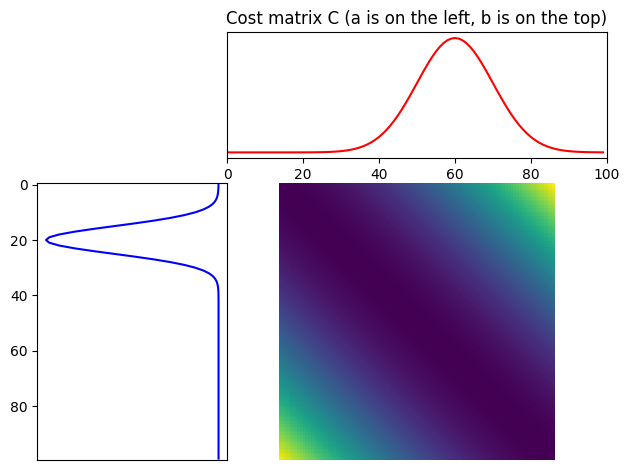

In [2]:
n = 100  # problem size

# Initialize marginals as normal distribution restricted to [0, n], normalized to 1
a = gauss(n, m=20, s=5)  # m=mean, s=std
b = gauss(n, m=60, s=10)

# Initialize cost matrix 
x = np.arange(n, dtype=np.float64)
C = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
C = C / C.max()

ot.plot.plot1D_mat(a, b, C, 'Cost matrix C (a is on the left, b is on the top)')

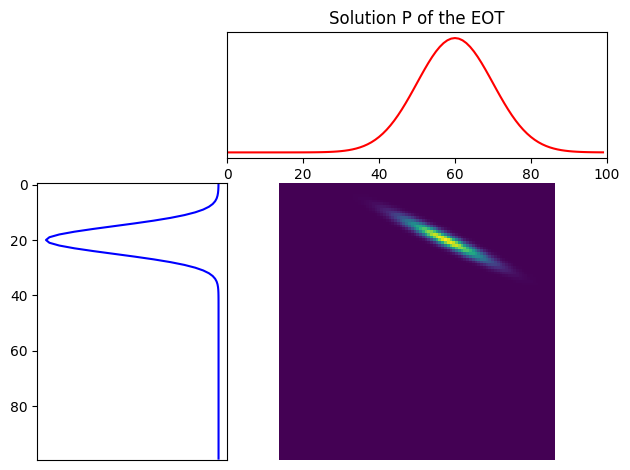

In [3]:
eps = .001  # Regularization parameter
n_iters = 1000  # Number of Sinkhorn iterations

K = np.exp(-C / eps)  # Compute the kernel matrix

# Initial choice for the scaling variables
u = np.ones(n)
v = np.ones(n)

# Run the Sinkhorn algorithm
for i in range(n_iters):
    u = a / (K @ v)
    v = b / (K.T @ u)

P = np.diag(u) @ K @ np.diag(v)  # Compute the transport plan from obtained scaling variables

ot.plot.plot1D_mat(a, b, P, 'Solution P of the EOT')

## Sinkhorn algorithm using POT
___
Fortunately, in POT (Python Optimal Transport) there is an implementation of the algorithm, 
incorporating some computational tricks to make the procedure faster and more stable.

Here is how usual call looks like:

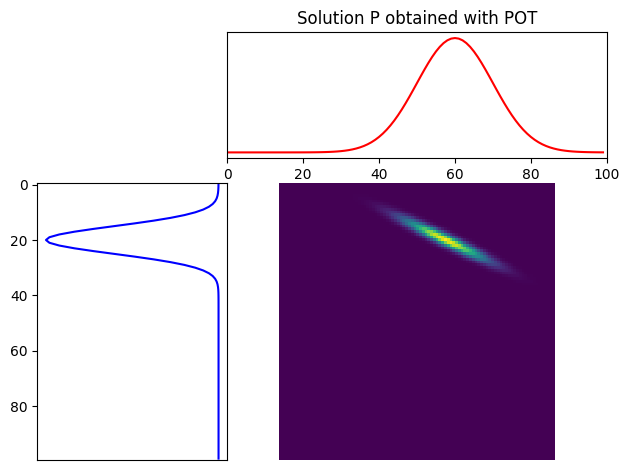

In [4]:
P_pot = ot.bregman.sinkhorn(a, b, C, eps, numItermax=n_iters)

ot.plot.plot1D_mat(a, b, P_pot, 'Solution P obtained with POT')

## Impact of the entropy term
___
If we play around with the regularization parameter, we may notice how EOT solution with small regularization value starts to look like transport plan, i.e. it becomes more sparse with value concentrated on the line.
And vice versa, the bigger $\varepsilon$, the closer solution approaches $\textbf{a}^T \textbf{b}$.

This behavior is fundamental property of EOT (see prop.4.1. in [1]), allowing us to approximate solution of the original problem.

Let's visualize how the solution changes depending on the value of $\varepsilon$:

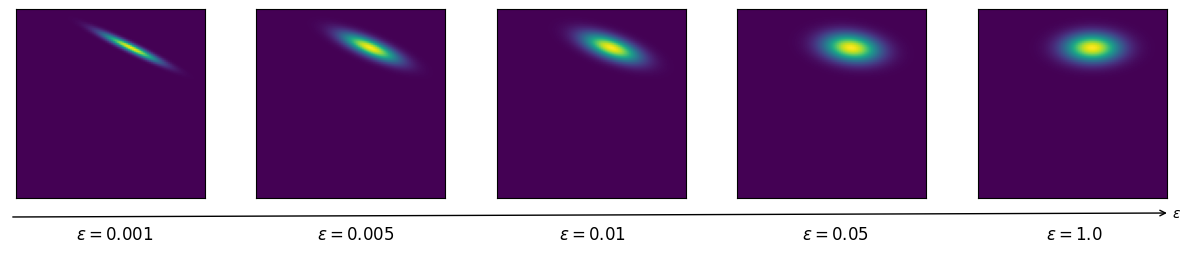

In [5]:
eps_list = [0.001, 0.005, .01, .05, 1.]  # List of regularizations to compute EOT (you can put your own)
n_plots = len(eps_list)

# Create a figure and a list of axes for the subplots
fig, axs = plt.subplots(1, n_plots, figsize=(3*n_plots, 3), sharey=True)

# Generate example data and plot each subplot
for ax, eps in zip(axs, eps_list):
    p = ot.bregman.sinkhorn(a, b, C, eps, numItermax=250)
    ax.imshow(p)

    # Hide x-axis labels and ticks for individual plots
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    

# Create an axis below all subplots for a common axis
fig.subplots_adjust(bottom=0.25)
common_ax = fig.add_subplot(111, label='common', frame_on=False)
common_ax.tick_params(labelcolor='black', top=False, bottom=False, left=False, right=False)

# Set ticks at positions corresponding to the center of each subplot
x_lims = (0, (3.5)*n_plots)
common_ax.set_xlim(*x_lims)
common_ax.set_xticks([])
common_ax.set_yticks([])
margin_width = (x_lims[1] - 3*n_plots) / (n_plots - 1)
tick_positions = []
curr_tick_p = 1.
for i in range(n_plots):
    common_ax.text(curr_tick_p, -0.19, r'$\epsilon=$'+f'${round(eps_list[i], 3)}$', fontsize=12, ha='left', va='center')#, xycoords='axes fraction')
    curr_tick_p += 3.6
    curr_tick_p *= 1.005

# Draw an arrowed axis
common_ax.annotate(r'$\varepsilon$', xy=(0, -0.1), xytext=(1, -0.1), xycoords='axes fraction', textcoords='axes fraction',
                   arrowprops=dict(arrowstyle="<-", color='black'))

fig.show()

## Examples
___
Below you can find various examples of EOT with different data

### Example 1: 3-marginal EOT
___


In [89]:
n = 100
# a = np.random.uniform(0, 1, n)
# a = a / a.sum()
# b = np.random.uniform(0, 1, n)
# b = b
# c = np.random.uniform(0, 1, n)
a = gauss(n, m=20, s=5)
b = gauss(n, m=60, s=10)
c = gauss(n, m=10, s=20)
C = np.zeros((n, n, n))
eps = .01
n_iters = 100

store_coord = 11.
for i in range(n):
    for j in range(n):
        for k in range(n):
            C[i, j, k] = (i - store_coord)**2 + (j - store_coord)**2 + (k - store_coord)**2
C = C / C.max()


u = np.ones(n)
v = np.ones(n)
w = np.ones(n)

K = np.exp(C/eps)
for i in range(n_iters):
    u = a / np.einsum('j, k, ijk -> i', v, w, K)
    v = b / np.einsum('i, k, ijk -> j', u, w, K)
    w = c / np.einsum('i, j, ijk -> k', u, v, K)

P = np.einsum('i, j, k, ijk -> ijk', u, v, w, C)

### Example 2: Interpolation with $\mathcal{W}_{2, \varepsilon}$-distance
___
For the time $t \in (0, 1)$ and given distributions $\mu_0, \mu_1$, we will look for a distribution $\mu_t$ such that
$$
    \mu_t = \arg\min_{\mu} (1 - t) \mathcal{W}^2_{2, \varepsilon}(\mu_0, \mu) + t \mathcal{W}_{2, \varepsilon}^2(\mu, \mu_1).
$$

The initial marginals are given by:

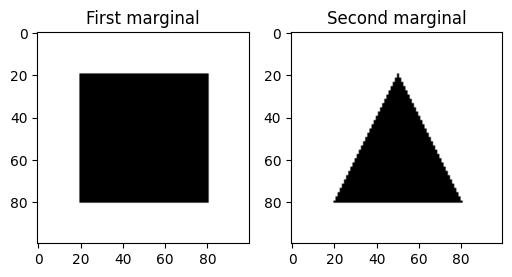

In [19]:
n_snapshots = 5

T = np.linspace(0, 1, n_snapshots)[1:-1]

img = Image.new('L', (100, 100), 'white')
draw = ImageDraw.Draw(img)
draw.rectangle([20, 20, 80, 80], fill='black')
a = np.asarray(img)
a = a / a.sum()

# Create an image with white background
img = Image.new('L', (100, 100), 'white')
draw = ImageDraw.Draw(img)
triangle_points = [(50, 20), (20, 80), (80, 80)]
draw.polygon(triangle_points, fill="black")
b = np.asarray(img)
b = b / b.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.imshow(a, cmap='gray')
ax1.set_title('First marginal')
ax2.imshow(b, cmap='gray')
ax2.set_title('Second marginal')

fig.show()

And here is how interpolation with $\mathcal{W}^2_{2, \varepsilon}$ looks like (have you noticed how the value of $\varepsilon$ changes the marginals?):

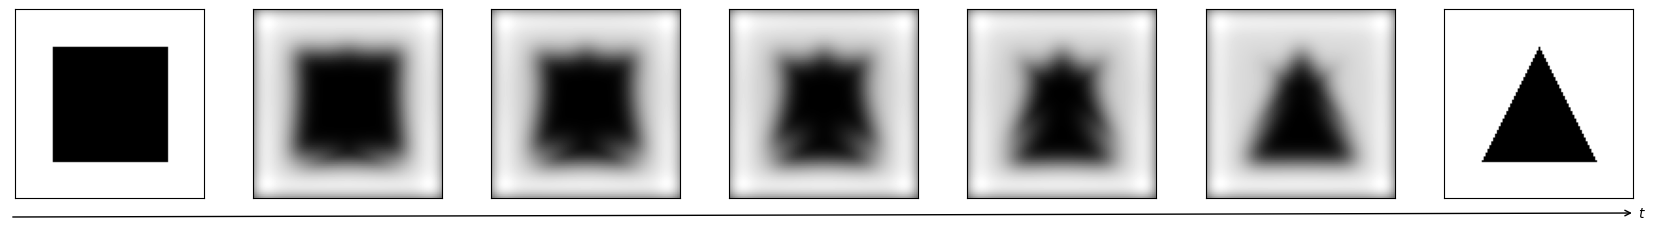

In [34]:
T = [0., .2, .35, .5, .7, .9, 1.]  # List of regularizations to compute EOT (you can put your own)
eps = 0.005  # Regularization parameter
n_iters = 500  # Number of Sinkhorn iterations

n_plots = len(T)

# Create a figure and a list of axes for the subplots
fig, axs = plt.subplots(1, n_plots, figsize=(3*n_plots, 3), sharey=True)


# Put original marginal as the first and the last pictures
axs[0].imshow(a, cmap='gray')
axs[0].set_xticks([])
axs[0].set_xticklabels([])
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[-1].imshow(b, cmap='gray')
axs[-1].set_xticks([])
axs[-1].set_xticklabels([])
axs[-1].set_yticks([])
axs[-1].set_yticklabels([])

# Generate example data and plot each subplot
for ax, t in zip(axs[1:-1], T[1:-1]):
    interp = ot.bregman.convolutional_barycenter2d(np.dstack([a.T, b.T]).T, weights=np.array([1-t, t]), reg=eps, numItermax=n_iters)
    ax.imshow(interp, cmap='gray')

    # Hide x-axis labels and ticks for individual plots
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    

# Create an axis below all subplots for a common axis
fig.subplots_adjust(bottom=0.25)
common_ax = fig.add_subplot(111, label='common', frame_on=False)
common_ax.tick_params(labelcolor='black', top=False, bottom=False, left=False, right=False)
common_ax.set_xticks([])
common_ax.set_yticks([])

# Draw an arrowed axis
common_ax.annotate(r'$t$', xy=(0, -0.1), xytext=(1, -0.1), xycoords='axes fraction', textcoords='axes fraction',
                   arrowprops=dict(arrowstyle="<-", color='black'))

fig.show()

Don't hesistate to try your own marginals!

### Example 3: Density fitting with $W_{2, \varepsilon}$-distance
___
In this example, the problem reads: for given distribution $\mu$, lets find a discrete distribution $\nu$ such that
$$
    \nu = \arg\min_{\omega} \mathcal{W}_{2, \varepsilon}^2(\mu, \omega).
$$

As a target distribution, lets fit discrete distribution to the uniform distribution on the 3-d sphere $U$.

The process looks like this. On $N$'th iteration, we update source distribution $U_{N - 1}$ following the procedure:
1. Obtain sample $\overline{U}$ from the $U$
2. Compute $W^2_{2, \varepsilon}(\overline{U}, U_{N - 1})$
3. Compute $\nabla_{U_{N - 1}} W^2_{2, \varepsilon}(\overline{U}, U_{N - 1})$
4. $U_N = U_{N - 1} - \lambda \nabla_{U_{N - 1}} W^2_{2, \varepsilon}(\overline{U}, U_{N - 1})$, where $\lambda > 0$ is learning rate.

Lets see how it performs!

In the code below, we'll be using ```torch``` library to perform auto gradients

In [2]:
import torch
import torch.nn.functional as F
from tqdm import trange

In [3]:
# Handy function for visualising data
def plot_sphere(ax):
    # Define the radius of the sphere
    radius = 1

    # Create a grid of points
    N = 30
    phi = np.linspace(0, np.pi, N)
    theta = np.linspace(0, 2 * np.pi, N)
    phi, theta = np.meshgrid(phi, theta)

    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

Here we initialise parameters for the algorithm, visualisation, and the initial distribution

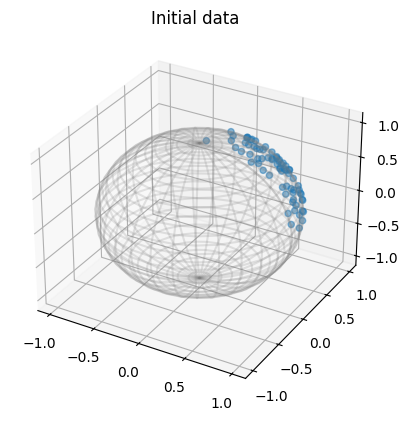

In [61]:
n_samples = 70  # Number of samples in 
n_projections = 50  # Number of samples of the uniform distribution

eps = 0.005  # Regularization parameter
n_iters = 10  # Number of Sinkhorn iterations

lrate = 5.  # Learning rate for gradient descent
grad_niters = 100  # Number of gradient descent iterations
visualize_iters = [0, 10, 20, 30, 40, 50, 60, 70, grad_niters-1]  # Which iterations to plot

x0 = torch.rand(n_samples, 3, dtype=torch.double)  # Initial data
x0 = F.normalize(x0, dim=-1)

ax = plt.axes(projection='3d')
plot_sphere(ax)
ax.scatter(x0[:, 0], x0[:, 1], x0[:, 2], alpha=0.5)
ax.set_title('Initial data')

plt.show()

Lets perform the gradient descent:

In [62]:
# Data points histograms
a = torch.ones(n_projections, dtype=torch.double)
a = a / a.sum()
b = torch.ones(n_samples, dtype=torch.double)
b = b / b.sum()

# Gradient descent
x = x0.clone()
x.requires_grad_(True)
torch.cuda.empty_cache()
vis_data = []
w22_vals = []
for ng in trange(grad_niters):
    if ng in visualize_iters:
        vis_data.append(x.clone().detach().numpy())

    sample = torch.tensor(ot.sliced.get_random_projections(3, n_projections).T, dtype=torch.double)  # Sample from the uniform distribution on a sphere

    C = torch.zeros((n_projections, n_samples), dtype=torch.double)
    for i in range(n_projections):
        for j in range(n_samples):
            C[i, j] = torch.linalg.norm(sample[i] - x[j])
    C = C / C.max()

    # Compute Wasserstein distance
    K = torch.exp(-C / eps)
    u = torch.ones(n_projections, dtype=torch.double)
    v = torch.ones(n_samples, dtype=torch.double)

    # Run the Sinkhorn algorithm
    for i in range(n_iters):
        u = a / (K @ v)
        v = b / (K.T @ u)

    # Compute value of W-distance
    p1 = torch.log(u) * eps
    p2 = torch.log(v) * eps
    w22 = torch.dot(p1, a) + torch.dot(p2, b) - eps * torch.sum(torch.diag(u) @ K @ torch.diag(v))

    w22_vals.append(w22.clone().detach().numpy())

    grad_x = torch.autograd.grad(w22, x)[0]  # Compute gradient w.r.t. data
    x = x - lrate * grad_x  # Perform the gradient descent iteration
    x = F.normalize(x, dim=-1)

100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


Here we can see how the $W^2_{2, \varepsilon}$ was decreasing throughout the iterations:

_(Note, that regularised Wasserstein distance in **not** a metric, mathematically speaking, so it need not to be always nonnegative)_

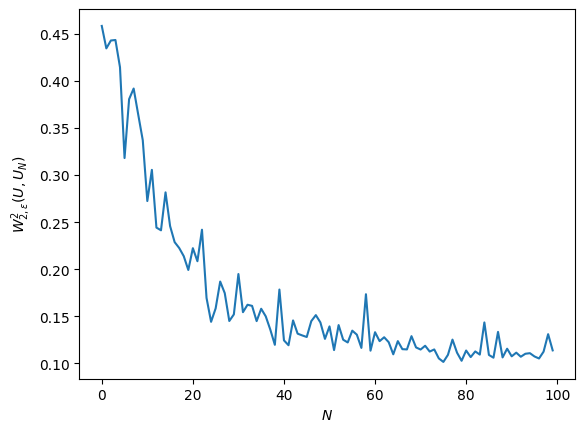

In [63]:
fig, ax = plt.subplots()

ax.plot(w22_vals)
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$W^2_{2, \varepsilon}(U, U_N)$')

fig.show()

Below we can see how the discrete distributing evolved, becoming more 'uniform':

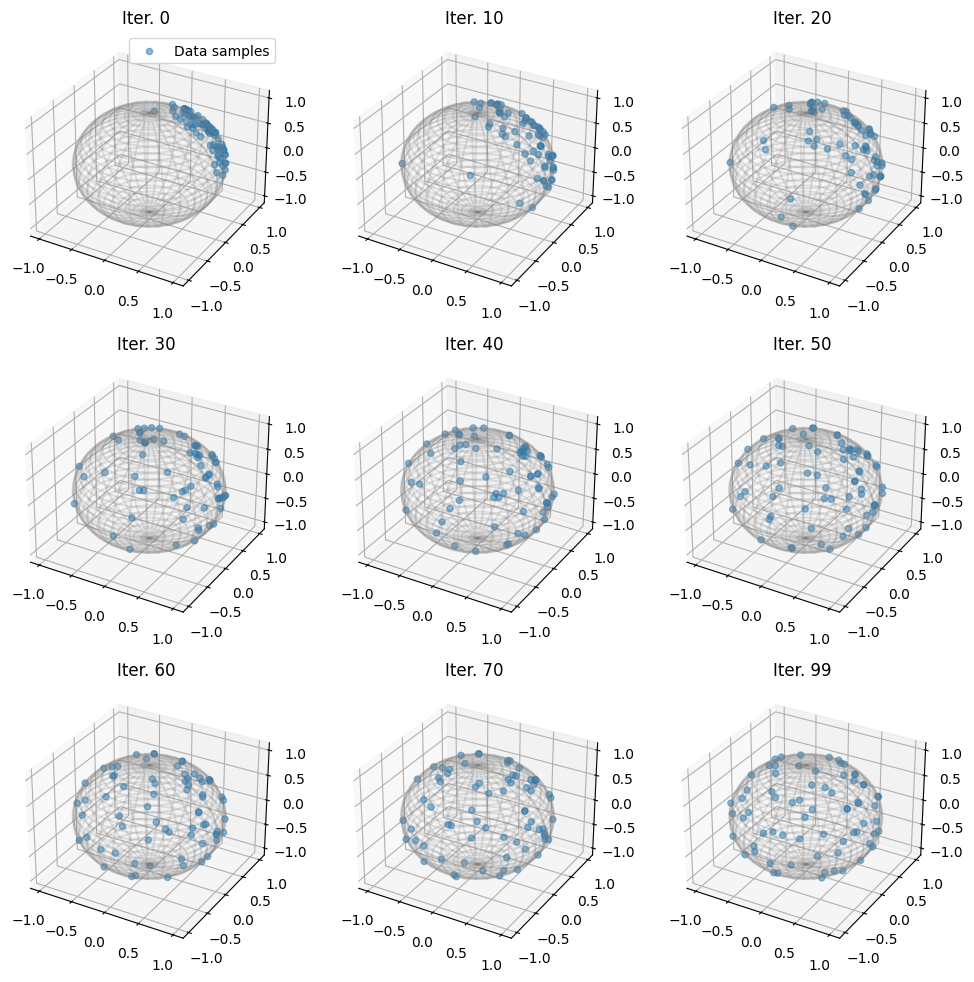

In [64]:
fig = plt.figure(3, (12, 12))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, projection='3d')
    plot_sphere(ax)
    ax.scatter(vis_data[i][:, 0], vis_data[i][:, 1], vis_data[i][:, 2], label='Data samples', alpha=0.5)
    ax.set_title('Iter. {}'.format(visualize_iters[i]))
    if i == 0:
        ax.legend()

## References
___
[1] Gabriel Peyré and Marco Cuturi, Computational Optimal Transport, 2018